# CID_SID ML model for TTR activators 

### Content   <a name="content"></a>

1. [Upload and create the DataFrame ](#1)
2. [Ensure an equal number of classes in the test sets](#2)
3. [Scaling](#3)
4. [Balancing](#4)
5. [Machine Learning](#5)
6. [Cross validation](#6)
7. [Scrutinise for overfitting](#7)
8. [Hyperparameter tuning with Optuna](#8)
9. [Scrutinise for overfitting of the ML model hyperparameter tuned by Optuna ](#9)
10. [Final ML model](#10)
11.  [Plot the learning curve ans AUC](#11)
12.  [Confusion matrix, classification report](#12)

## Upload and analyse PubChem BioAssay AID 652054 on D3 receptor <a name="1"></a>

In [1]:
import os
import pandas as pd 

# Navigate to the files
file_path = os.path.join("..", 'TTR/input', "CID_SID_targets.csv")

# load the data frames
df = pd.read_csv(file_path)

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (3174, 3)


,CID,SID,target
0,657961,856604,1
1,2988615,49642431,0
2,16682357,26663415,0
3,1595007,26671459,0
4,831629,49641321,0


In [2]:
# Remove duplicates 
df.drop_duplicates()
df.shape  

(3174, 3)

In [3]:
# Count the target value
df['target'].value_counts()

target
0    2020
1    1154
Name: count, dtype: int64

[<a href="#content">Back to top</a>]

## Ensure an equal number of classes in the test sets <a name="2"></a>

In [4]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract 2800 samples (10% of 28000 samples) of target 1 for the test set
df_1_test = df_1.iloc[:340] 

# Assign the rest of target 1 for the train set
df_1_train = df_1.iloc[341:]

In [5]:
# Handle the part of target 1 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

## Extract 10% of the target 0 for  the test set
df_0_test = df_0.iloc[:340]

# Assign the rest of target 1 for the train set
df_0_train = df_0.iloc[341:]

In [6]:
# Create train and test dataframe for further manipulation 
train = pd.concat([df_0_train, df_1_train])
test = pd.concat([df_0_test, df_1_test])

In [7]:
# Create the sets for ML 
X_train = train.drop(columns='target', axis=1)
y_train = train['target']
X_test =  test.drop(columns='target', axis=1)
y_test = test['target']

In [8]:
# Create the sets for Cross-validation
X = pd.concat([X_train, X_test])
y = pd.concat([y_train,y_test])

In [9]:
# Check the number of classes in the y_test set
y_test.value_counts()

target
0    340
1    340
Name: count, dtype: int64

[<a href="#content">Back to top</a>]

## Scaling <a name="3"></a>

In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# # Standardise the data points
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (2492, 2)
X_test:   (680, 2)
y_train:  (2492,)
y_test:   (680,)


[<a href="#content">Back to top</a>]

## Balancing <a name="4"></a>

[(0, 1679), (1, 813)]


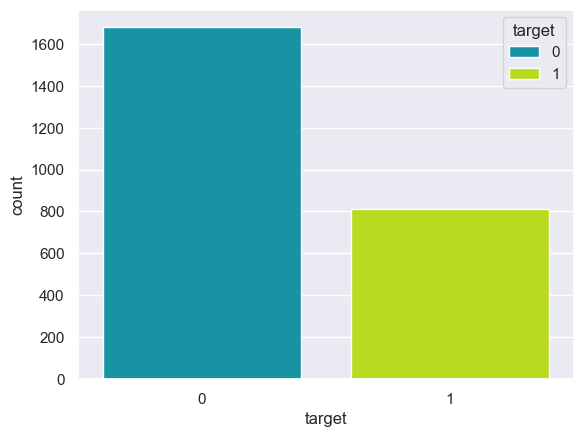

In [11]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the imbalance between the targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 1679), (1, 1679)]


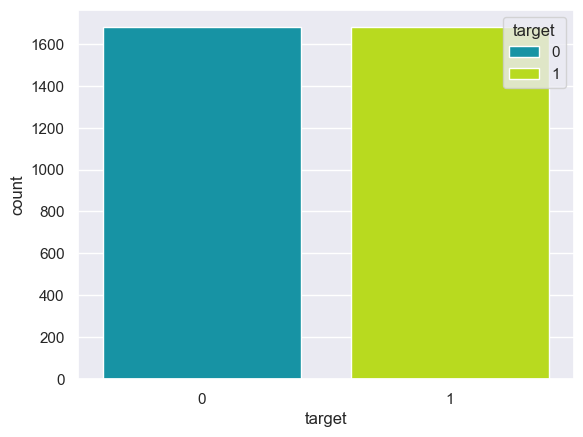

In [12]:
from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler

# Balance targets with Synthetic Minority Oversampling Technique
smote = SMOTE(random_state=0)
# ros = RandomOverSampler()

X_train, y_train = smote.fit_resample(X_train, y_train)

# Plot the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [13]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (3358, 2)
X_test:   (680, 2)
y_train:  (3358,)
y_test:   (680,)


[<a href="#content">Back to top</a>]

## Machine Learning <a name="5"></a>

In [14]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the algorithms that will be used, placing them in a dictionary 
clfs = {"SVM":SVC(kernel='rbf', C=1, probability=True),
        "Decision":DecisionTreeClassifier(), 
        "RandomForest":RandomForestClassifier(), 
        "GradientBoost":GradientBoostingClassifier(),
        "K-nearest": KNeighborsClassifier(n_neighbors=3)
       }

In [15]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Create statistics with the results of training with different algorithms
def model_fit(clfs):
    fitted_model={}
    model_result = pd.DataFrame()
    # Iterate the clfs dictionary clfs
    for model_name, model in clfs.items():
        # Train the current model
        model.fit(X_train,y_train)
        # Add the current model name
        fitted_model.update({model_name:model})
        # Prediction of the current model 
        y_pred = model.predict(X_test)
        model_dict = {}
        model_dict['1.Algorithm'] = model_name
        # Calculate the metrics
        model_dict['2.Accuracy'] = round(accuracy_score(y_test, y_pred),3)
        model_dict['3.Precision'] = round(precision_score(y_test, y_pred),3)
        model_dict['4.Recall'] = round(recall_score(y_test, y_pred),3)
        model_dict['5.F1'] = round(f1_score(y_test, y_pred),3)
        model_dict['6.ROC'] = round(roc_auc_score(y_test, y_pred),3)
        model_result = model_result._append(model_dict,ignore_index=True)
    return fitted_model, model_result

# Run the function model_fit(clfs) 
fitted_model, model_result = model_fit(clfs)

# Display the results of the model_fit(clfs) function in a descending order
model_result.sort_values(by=['2.Accuracy'],ascending=False)

,1.Algorithm,2.Accuracy,3.Precision,4.Recall,5.F1,6.ROC
3,GradientBoost,0.815,0.946,0.668,0.783,0.815
4,K-nearest,0.791,0.844,0.715,0.774,0.791
2,RandomForest,0.785,0.844,0.700,0.765,0.785
0,SVM,0.774,0.970,0.565,0.714,0.774
1,Decision,0.740,0.774,0.676,0.722,0.740


[<a href="#content">Back to top</a>]

## Cross-validation  <a name="6"></a>

In [16]:
# Cross validation
from sklearn.model_selection import cross_val_score
import numpy as np

# Create statistics with the results of the cross-validation of different estimators
def model_CV(clfs):
    estimated_model={}
    model_cv_result = pd.DataFrame()
    for model_name, model in clfs.items():
        estimated_model.update({model_name:model})
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        model_dict = {}
        model_dict['1.Algorithm'] = model_name
        model_dict['2.Mean CV Score'] = round(scores.mean(), 4)
        model_dict['3.Standard Deviation'] = round(scores.std(), 4)
        model_dict['4.List of CV Scores'] = np.round(scores, 4)
        model_cv_result = model_cv_result._append(model_dict,ignore_index=True)
    return estimated_model, model_cv_result

# Run the model_CV(clsf) function
estimated_model, model_cv_result = model_CV(clfs)

# Display the results of cross_validation statistics in a descending order
model_cv_result.sort_values(by=['2.Mean CV Score'],ascending=False)

,1.Algorithm,2.Mean CV Score,3.Standard Deviation,4.List of CV Scores
3,GradientBoost,0.8458,0.0085,"[0.8472, 0.852, 0.8297, 0.847, 0.8533]"
2,RandomForest,0.8301,0.0055,"[0.8205, 0.8362, 0.8312, 0.8281, 0.8344]"
4,K-nearest,0.8175,0.0067,"[0.8205, 0.8157, 0.8076, 0.8155, 0.8281]"
0,SVM,0.8108,0.0139,"[0.8079, 0.8205, 0.8155, 0.7855, 0.8249]"
1,Decision,0.7799,0.0078,"[0.7811, 0.7874, 0.7681, 0.7744, 0.7886]"


[<a href="#content">Back to top</a>]

## Scrutinise for overfitting  <a name="7"></a>

In [17]:
# Evaluate XGBClassifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = GradientBoostingClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.799, test: 0.799
>2, train: 0.816, test: 0.821
>3, train: 0.833, test: 0.815
>4, train: 0.876, test: 0.803
>5, train: 0.897, test: 0.804
>6, train: 0.920, test: 0.809
>7, train: 0.940, test: 0.801
>8, train: 0.970, test: 0.787
>9, train: 0.981, test: 0.787
>10, train: 0.993, test: 0.782
>11, train: 0.995, test: 0.769
>12, train: 1.000, test: 0.768
>13, train: 1.000, test: 0.774
>14, train: 1.000, test: 0.768
>15, train: 1.000, test: 0.768
>16, train: 1.000, test: 0.763
>17, train: 1.000, test: 0.756
>18, train: 1.000, test: 0.760
>19, train: 1.000, test: 0.760
>20, train: 1.000, test: 0.757


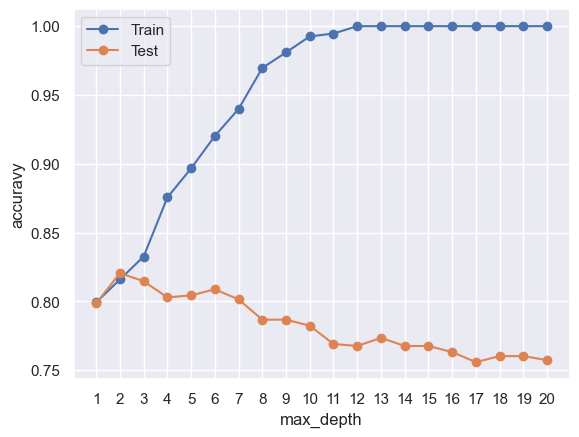

In [18]:
import math

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

[<a href="#content">Back to top</a>]

## Hyperparameter tuning with Optuna<a name="8"></a>

In [19]:
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning.

    Args:
        trial: An Optuna trial object.

    Returns:
        The negative accuracy score (to be minimized).
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), 
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = GradientBoostingClassifier(**params, random_state=42) 
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -accuracy  # Optuna minimizes the objective function

# Create a study object
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
best_model = GradientBoostingClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Best Accuracy: {accuracy}")
print(f"Best Hyperparameters: {best_params}")

[I 2025-05-15 19:45:48,179] A new study created in memory with name: no-name-9f798863-3378-435e-ab7a-273d0c21c53a
[I 2025-05-15 19:45:54,265] Trial 0 finished with value: -0.8109032361081541 and parameters: {'n_estimators': 187, 'learning_rate': 0.27190357353509836, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: -0.8109032361081541.
[I 2025-05-15 19:45:56,628] Trial 1 finished with value: -0.8159676389184586 and parameters: {'n_estimators': 121, 'learning_rate': 0.22767933593285353, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 9}. Best is trial 1 with value: -0.8159676389184586.
[I 2025-05-15 19:46:00,998] Trial 2 finished with value: -0.8168627137889434 and parameters: {'n_estimators': 133, 'learning_rate': 0.1729052554098199, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 2 with value: -0.8168627137889434.
[I 2025-05-15 19:46:04,865] Trial 3 finished with value: -0.8091161911858633 and param

Best Accuracy: 0.8073529411764706
Best Hyperparameters: {'n_estimators': 127, 'learning_rate': 0.0689071643153505, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 7}


[<a href="#content">Back to top</a>]

## Scrutinise for overfitting of the MLmodel hyperparameter tuned by Optuna  <a name="9"></a>

In [21]:
# Evaluate random forest classifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = GradientBoostingClassifier(max_depth=i, 
                                    n_estimators = 127,
                                    learning_rate = 0.0689071643153505, 
                                    min_samples_split = 12, 
                                    min_samples_leaf = 7)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.799, test: 0.799
>2, train: 0.812, test: 0.809
>3, train: 0.832, test: 0.810
>4, train: 0.852, test: 0.807
>5, train: 0.873, test: 0.801
>6, train: 0.894, test: 0.807
>7, train: 0.904, test: 0.801
>8, train: 0.921, test: 0.801
>9, train: 0.927, test: 0.806
>10, train: 0.938, test: 0.800
>11, train: 0.947, test: 0.796
>12, train: 0.955, test: 0.794
>13, train: 0.965, test: 0.799
>14, train: 0.971, test: 0.800
>15, train: 0.973, test: 0.794
>16, train: 0.977, test: 0.793
>17, train: 0.985, test: 0.782
>18, train: 0.984, test: 0.775
>19, train: 0.986, test: 0.779
>20, train: 0.990, test: 0.778


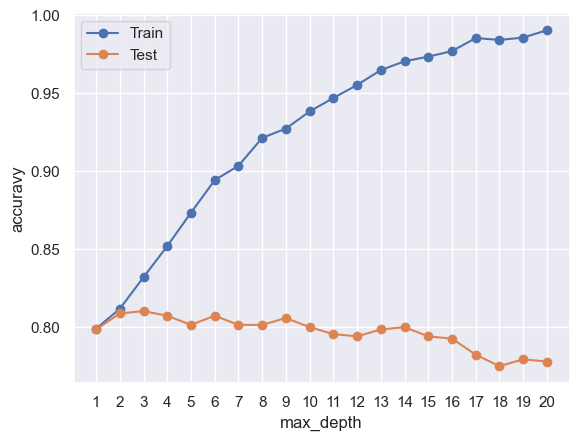

In [22]:
# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

[<a href="#content">Back to top</a>]

## Final ML model  <a name="10"></a>

In [23]:
# ML with hyperparameters sugested by the grid search 
model = GradientBoostingClassifier(max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.815
Precision:  0.946
Recall:  0.668
F1:  0.783
ROC:  0.815


In [25]:
# Perform 5-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", np.round(scores, 3))
print("Mean cross-validation score:", np.round(scores.mean(), 3))

Cross-validation scores: [0.796 0.81  0.79  0.788 0.844]
Mean cross-validation score: 0.806


[<a href="#content">Back to top</a>]

## Plot the learning curve and AUC <a name="11"></a>

C:\Users\ivano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ivano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ivano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ivano\AppDat

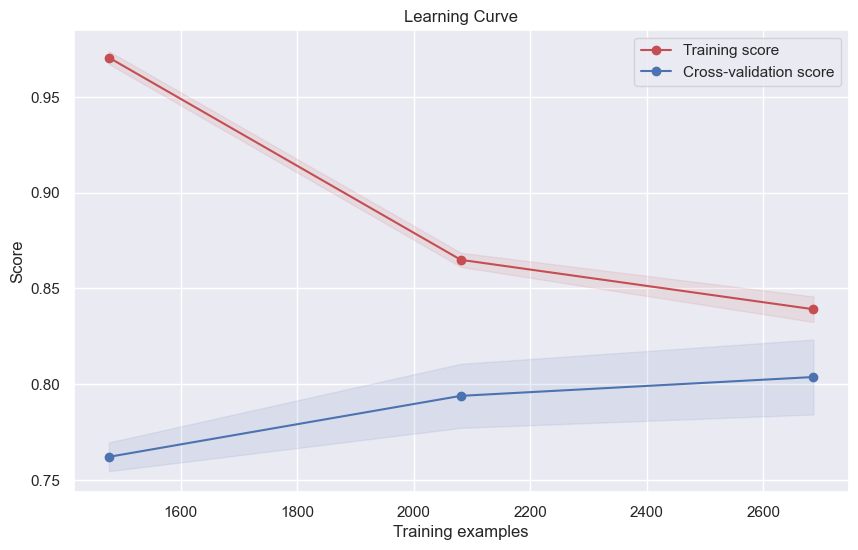

In [27]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="b",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[<a href="#content">Back to top</a>]

## Confusion matrix, classification report <a name="12"></a>

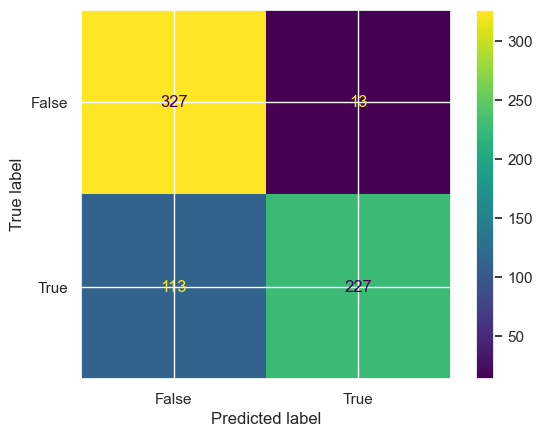

In [28]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Random forest classifier prediction
predicted = model.fit(X_train, y_train).predict(X_test)

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted)

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [29]:
# Classification report 
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, predicted, target_names=target_names))

                     precision    recall  f1-score   support

 Active (target 1)        0.74      0.96      0.84       340
Inactive (target 0)       0.95      0.67      0.78       340

           accuracy                           0.81       680
          macro avg       0.84      0.81      0.81       680
       weighted avg       0.84      0.81      0.81       680



[<a href="#content">Back to top</a>]